# Proyecto para introducción a la ciencia de redes: $\texttt{VoterModel_v1}$.

### **Joshua Briones Andrade**

----------------------------

### Resumen:

Se desarrolló un modelo de votantes para k-partidos en redes con la implementación del modelo de Ising para poder simular la dinámica de una elección política con variaciones estocásticas a partir de redes de amistad o redes sociales entre individuos.

### Objetivo: 

El objetivo principal del proyecto es determinar estados los estables y los estados metaestables en una simulación sobre una red de mundo pequeño (modelo W-S), donde hay $N$ nodos (personas) con $s$ vecinos cercanos al ir variando la probabilidad de reconexión $p_w$ de 0 a 0.5.

Una vez determinada la red a analizar, se puede experimentar con el término de
temperatura $T$ y aumentar la probabilidad de generar un cambio de opinión aleatorio en los individuos y así en enriquecer el análisis al incorporar interacciones complejas y mejorar la estadística del modelo.

In [1]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://github.com/joshbrx/VoterModel_Network/blob/main/imgs/metropolis.jpg?raw=true")

-------------------------------

Se agregan las librerías necesarias para poder implementar el código. También se agregan opciones para la visualización y el análisis de las redes a partir de sus variables macroscópicas ($k$, $C$, $l$, etcétera).

In [2]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import random
from itertools import count

In [3]:
colors = ["tab:purple", "tab:orange", "tab:green",  "yellow", "white"]   # |colors| = 5

In [4]:
options1 = {"edge_color": "tab:gray",  "node_size": 800, "alpha": 0.9, 
           "node_color": "tab:red", "font_size": 20, "font_color":"whitesmoke"}

options2 = {"edge_color": "0.1",  "node_size": 600, "alpha": 1, 
           "node_color": "tab:purple", "font_size": 15, "font_color":"whitesmoke"}

options3 = {"edge_color": "0.1",  "node_size": 200, "alpha": 1, 
           "node_color": "tab:purple", "font_size": 10, "font_color":"whitesmoke"}

options3b= {"edge_color": "0.1",  "node_size": 200, "alpha": 1, 
           "font_size": 10, "font_color":"whitesmoke"}

options4 = {"edge_color": "0.2",  "node_size": 50, "alpha": 1,
           "node_color": "tab:purple", "font_size": 4, "font_color":"whitesmoke"}

options4b= {"edge_color": "0.2",  "node_size": 50, "alpha": 1,
            "font_size": 4, "font_color":"whitesmoke"}

options5 = {"edge_color": "0.8",  "node_size": 15, "alpha": 0.7, "width": 1,
           "node_color": "tab:purple", "font_size": 0, "font_color":"whitesmoke"}

options5b= {"edge_color": "0.8",  "node_size": 15, "alpha": 0.7, "width": 1,
             "font_size": 0, "font_color":"whitesmoke"}

options6 = {"edge_color": "0.2",  "node_size": 0, "alpha": 1, "width": 0.2,
           "node_color": "tab:purple", "font_size": 0, "font_color":"whitesmoke"}

options7 = {"edge_color": "0.5",  "node_size": 0, "alpha": 1, "width": 0.05,
           "node_color": "tab:purple", "font_size": 0, "font_color":"whitesmoke"}

In [5]:
def degree_analysis(G, pos=None, title=None, with_labels=False, **options):
    
    s2, s3 = [], []
    degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
    dmax = max(degree_sequence)

    fig = plt.figure(figsize=(12, 6.5))
    # Create a gridspec for adding subplots of different sizes
    axgrid = fig.add_gridspec(6,5)

    ax0 = fig.add_subplot(axgrid[:,0:3])
    Gcc = G.subgraph(sorted(nx.connected_components(G), key=len, reverse=True)[0])

    if pos == None:
        nx.draw(G, with_labels=with_labels, **options)
    else: 
        nx.draw(G, pos, with_labels=with_labels, **options)

    ax0.set_title(title)
    ax0.set_axis_off()

    ax1 = fig.add_subplot(axgrid[:2, 3:])
    k_mean = np.mean(degree_sequence)
    title1 = r"Distribución de grado: $\langle k\rangle=$" + str(k_mean)
    y1, x1 = np.unique(degree_sequence, return_counts=True)
    sns.histplot(data=degree_sequence, stat='probability', common_bins=True, common_norm=True,
                 color="orange", multiple='layer', element='bars', shrink=0.8, discrete=1)
    ax1.set_title(title1)
    ax1.set_xlabel("$k$")
    ax1.set_ylabel("$P(k)$")

    
    p2 = nx.clustering(G)
    for key in p2:
        s2.append(p2[key])
    s2 = np.array(s2)
    ax2 = fig.add_subplot(axgrid[2:4, 3:])
    c_mean = np.mean(s2)
    title2 = r"Clustering coefficient: $\langle C\rangle=$" + str(c_mean)
    sns.histplot(data=s2, stat='probability', common_bins=True, common_norm=True,
                 color="orange", multiple='layer', element='bars', shrink=0.8)
    ax2.set_title(title2)
    ax2.set_xlabel("$C$")
    ax2.set_ylabel("$P(C)$")

    
    p3 = dict(nx.shortest_path_length(G))
    for i in p3:
        for j in p3[i]:
            if i == j:
                pass
            else:
                s3.append(p3[i][j])
    s3 = np.array(s3)
    ax3 = fig.add_subplot(axgrid[4:, 3:])
    l_mean = np.mean(s3)
    title3 = r"Shortest-path length: $\langle l\rangle=$" + str(l_mean)
    sns.histplot(data=s3, stat='probability', common_bins=True, common_norm=True,
                 color="orange", multiple='layer', element='bars', shrink=0.8, discrete=1)
    ax3.set_title(title3)
    ax3.set_xlabel("$l$")
    ax3.set_ylabel("$P(l)$")

    fig.tight_layout()
    plt.show()

### **Paso 1**: Generar la red de W-S y calcular sus variables macroscópicas (distribución de grado, clustering coefficient, shortest-path length, etcétera).

In [6]:
#Se añaden las semillas para trabajar con las mismas gráficas y visualizaciones
seed_graph = 14518965126 

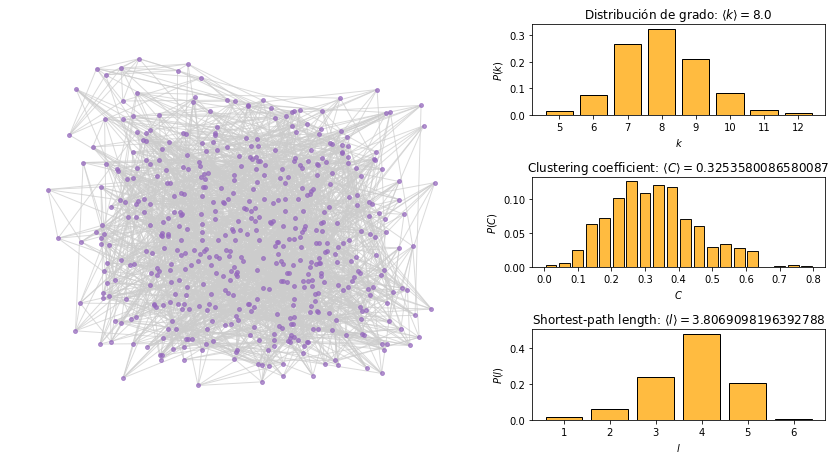

In [7]:
n = [50, 100, 500, 1000]
k = [2, 4, 6, 8]
p = np.logspace(-3, 0, num=10)

G = nx.watts_strogatz_graph(n[2], k[3], p[7], seed=seed_graph)
pos = nx.spring_layout(G, iterations = 5)
degree_analysis(G, pos=pos, title=None, with_labels=False, **options5)

### **Paso 2**: Generar la configuración inicial al establecer de manera aleatoria la preferencia de cada nodo por un estado. Se sugiere tener una proporción 50-50 inicial.

In [8]:
def initialize(G, ratios):
    states = dict()
    if np.sum(ratios) < 1:
        ratios.append(1-np.sum(ratios))
    else: pass
    state_list = [i for i in range(len(ratios))]
    for node in G.nodes:
        states[node] = random.choices(state_list, weights = ratios, k = 1)[0]
    nx.set_node_attributes(G, states, "state")
    return G, state_list
# --------------------------------------------------------------------------
def color_by_state(G, colors):
    node_color = []
    for node in G.nodes(data=True):
        # print(node[1]["state"])
        node_color.append(colors[node[1]["state"]])
    return node_color

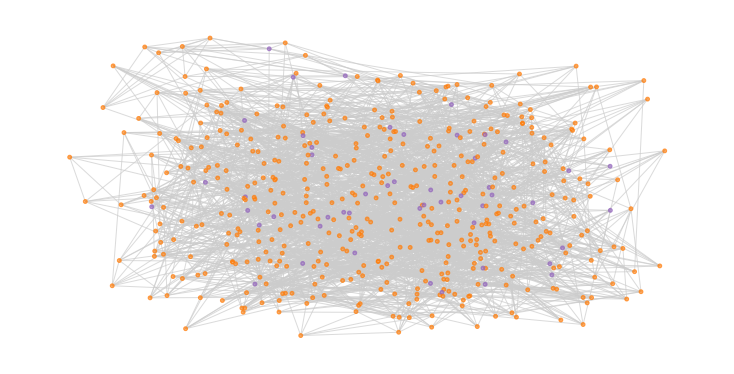

In [9]:
ratios = [0.1, 0.9]

G, state_list = initialize(G, ratios)
node_color = color_by_state(G, colors)

plt.figure(figsize=(10,5))
nx.draw(G, pos, node_color=node_color, with_labels=True, **options5b)

### **Paso 3**: Definir las funciones para la energía de cada nodo a partir de sus vecinos

In [10]:
def delta(a,b):
    if a - b == 0:
        s = 1
    else: s =- 1
    return s
# --------------------------------------------------------------------------
def node_energy(G, node, J=0.5):
    s = 0;
    for i in G.neighbors(node):
        s += delta(G.nodes[i]["state"], G.nodes[node]["state"])
    return -J*s
# --------------------------------------------------------------------------
def neighbors_energy(G, node, J=0.5):
    s = node_energy(G, node, J=J)
    for i in G[node]:
        s += - node_energy(G, i)
    return s
# --------------------------------------------------------------------------
def graph_energy(G, J=0.5):
    s = 0
    for i in range(len(G)):
        s += node_energy(G, list(G)[i], J=J)
    return s

In [11]:
J = 0.5; K_B = 1;
node = 10

node_energy(G, node, J=J), neighbors_energy(G, node, J=J), graph_energy(G, J=J)

(-3.0, 11.5, -1270.0)

### **Paso 3**: Armar el modelo de Ising con el operador de evolución (voltear espín, y aceptar o rechazar el nuevo estado).

In [12]:
np.floor(random.random()*7)

1.0

In [13]:
def change_state(G, node, state_list, p_ratios):
    state = G.nodes(data=True)[node]["state"]
    s = random.choices(state_list, weights=p_ratios)[0]
    while s == state:
        s = random.choices(state_list, weights=p_ratios)[0]
    return state_list[(state+1)%len(state_list)]
# --------------------------------------------------------------------------
def flip_spin(G, p_ratios, state_list=state_list, flips=1):
    G2 = G.copy(as_view=False)

    for i in range(flips):
        node_index = random.choices(list(G))[0]
        G2.nodes(data=True)[node_index]["state"] = change_state(G, node_index, state_list, p_ratios)
        
    e_2 = graph_energy(G2, J=J)

    return G2, e_2
# --------------------------------------------------------------------------
def accept_flip(G, T, p_ratios, state_list=state_list, flips=1, printed=False):
    G2, e_2= flip_spin(G, p_ratios, state_list=state_list, flips=flips)
    e_1 = graph_energy(G, J=J)
    e = e_2-e_1
    r = np.random.uniform(0,1)
    p = min(1, np.exp(-e/T))
    # print(e_1,e_2)
    if p - r > 0:
        G = G2
        if printed==True:
            print("Accepted!")
        else: pass
    else: pass
    return G

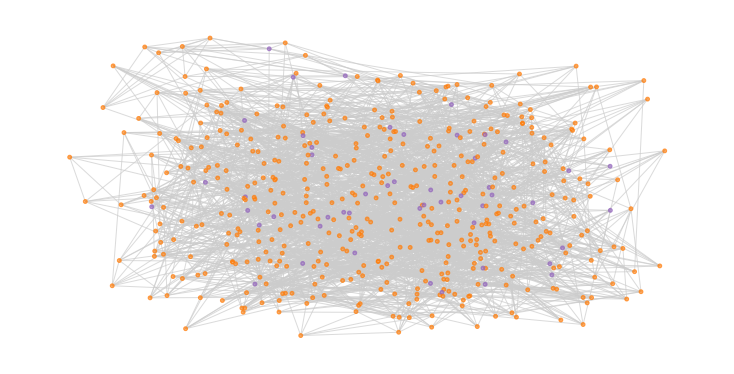

In [14]:
flips = 10
p_ratios = [1 for i in range(len(ratios))]

G = accept_flip(G, 0.1, p_ratios, state_list=state_list, flips=flips, printed=True)
node_color = color_by_state(G, colors)

plt.figure(figsize=(10,5))
nx.draw(G, pos, node_color=node_color, with_labels=True, **options5b)

### **Paso 4**: Evolucionar la red de manera natural un cierto número de pasos y calcular las proporciones de nodos de cada estado.

In [15]:
def evolve_graph(G, T, pasos, p_ratios = p_ratios, state_list=state_list, flips=1):
    config = []
    for i in np.arange(pasos):
        config.append(G) 
        G= accept_flip(G, T, p_ratios, state_list=state_list, flips=flips)
    return config

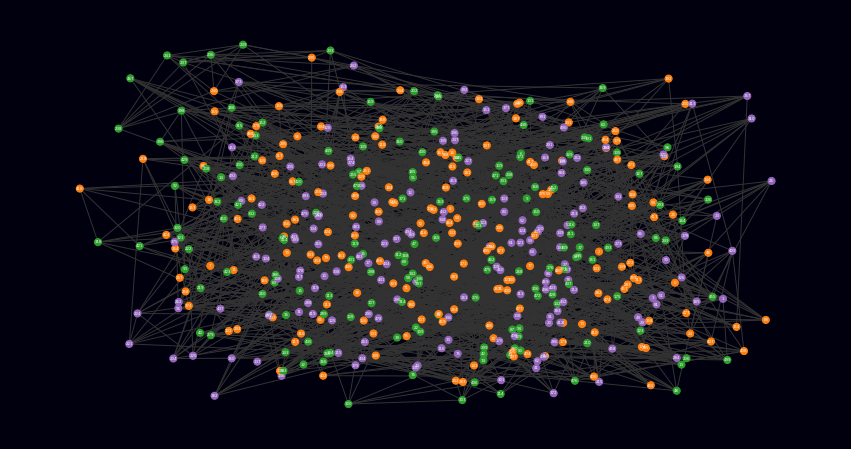

In [39]:
flips = 3
ratios = [0.334, 0.333, 0.333]
p_ratios = [0.9, 0.05, 0.05]

G, state_list = initialize(G, ratios)
node_color = color_by_state(G, colors)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,8))
nx.draw(G, pos, node_color=node_color, with_labels=True, **options4b)
ax.set_facecolor('#00000F'); ax.axis('off')
fig.set_facecolor('#00000F')

GG = evolve_graph(G, 1.0, 10000, p_ratios = p_ratios, state_list=state_list, flips=flips)

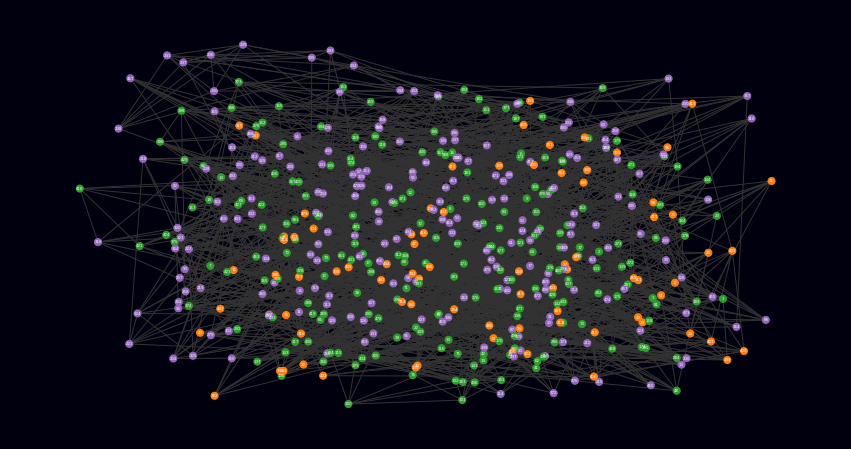

In [40]:
node_color2 = color_by_state(GG[-1], colors)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,8))
nx.draw(GG[-1], pos, node_color=node_color2, with_labels=True, **options4b)
ax.set_facecolor('#00000F'); ax.axis('off')
fig.set_facecolor('#00000F')

## Análisis cuantitativo de la evolución

In [98]:
def evol_energy(GG):
    array_energy = np.zeros(len(GG))
    for i in range(len(GG)):
        array_energy[i] = graph_energy(GG[i], J=0.5)
    return array_energy
# --------------------------------------------------------------------------
def evol_proportions(GG, state_list):
    N = len(GG);
    l = len(state_list)
    array_prop = np.zeros((N, l))
    for i in range(N):
        for j in range(l):
            array_prop[i,j] = len([x for x,y in GG[i].nodes(data=True) if y['state']==state_list[j]])
    return array_prop
# --------------------------------------------------------------------------
def evol_separability(array_prop):
    N, l = array_prop.shape
    array_sep = np.zeros(N)
    for i in range(N):
        array_sep[i] = array_prop[i,0]
        for j in range(1, l):
            array_sep[i] *= array_prop[i, j]
    s = np.log(array_sep)
    return s/(np.log(N))

In [41]:
test_energy = evol_energy(GG)
test_prop = evol_proportions(GG, state_list)

In [99]:
test_sep = evol_separability(test_prop)

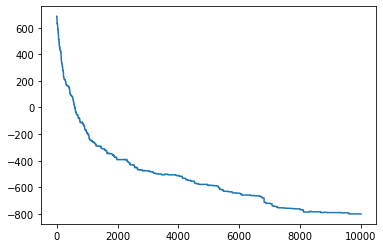

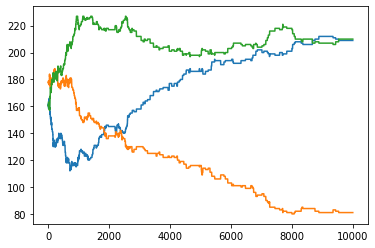

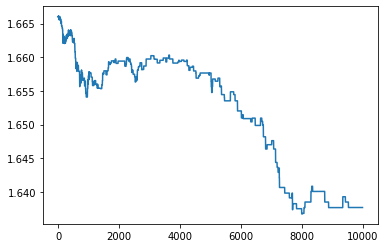

In [100]:
plt.plot(test_energy)
plt.show() 
plt.plot(test_prop)
plt.show() 
plt.plot(test_sep)
plt.show() 

# Comparación con red de investigación científica

In [22]:
df = pd.read_csv("https://raw.githubusercontent.com/joshbrx/VoterModel_Network/main/Datasets/netscience/ca-netscience/ca-netscience.txt",
                 sep="\s", comment='%',  names=["In", "Out"], index_col=False)
df.head()

edge_list = []                       # extrayendo lista de aristas
for i in range(len(df)-1):
    edge_list.append((df.to_numpy()[i][0], df.to_numpy()[i][1]))

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [23]:
def make_graph(edge_list):
    G = nx.Graph()
    G.add_edges_from(edge_list)
    return G

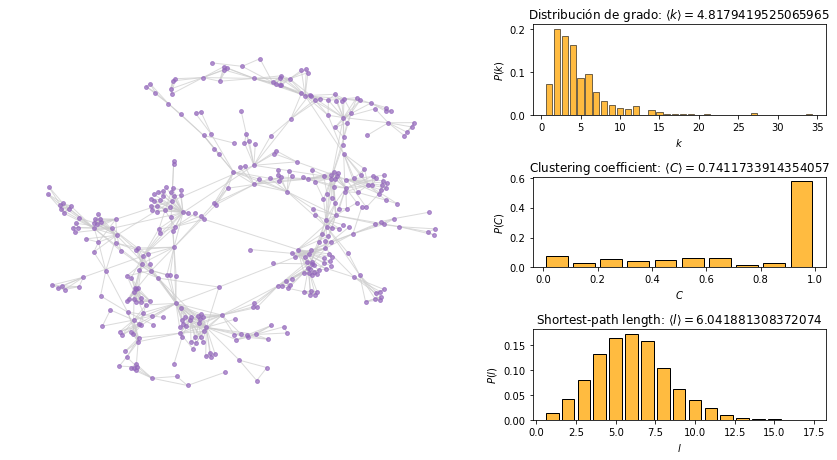

In [24]:
G_science = make_graph(edge_list)

pos_science = nx.spring_layout(G_science, iterations = 105, k=len(G_science)**(-1/4), seed=0)
degree_analysis(G_science, pos=pos_science, title=None, with_labels=False, **options5)
# len(G_science) = 379

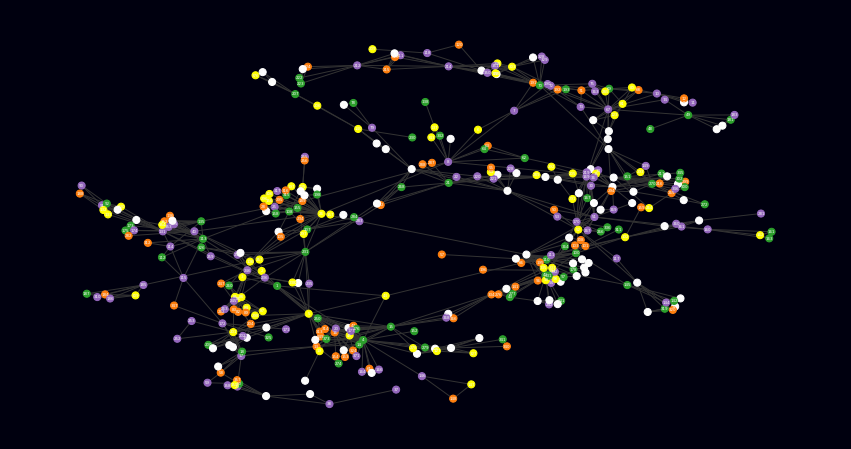

In [69]:
flips = 4
ratios = [1/5, 1/5, 1/5, 1/5, 1/5]
p_ratios = [1/5, 1/5, 1/5, 1/5, 1/5]

G_science, state_list = initialize(G_science, ratios)
node_color = color_by_state(G_science, colors)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,8))
nx.draw(G_science, pos_science, node_color=node_color, with_labels=True, **options4b)
ax.set_facecolor('#00000F'); ax.axis('off')
fig.set_facecolor('#00000F')

GG_science = evolve_graph(G_science, 0.05, 10000, p_ratios = p_ratios, state_list=state_list, flips=flips)

In [70]:
science_energy = evol_energy(GG_science)
science_prop = evol_proportions(GG_science, state_list)

In [101]:
science_sep = evol_separability(science_prop)

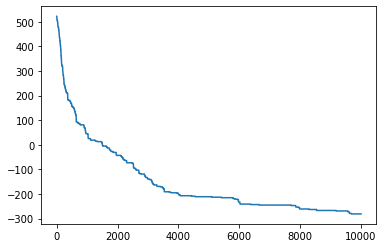

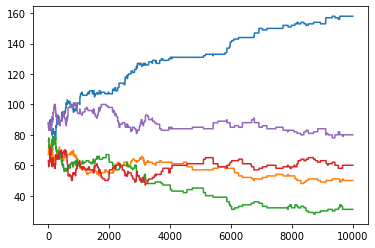

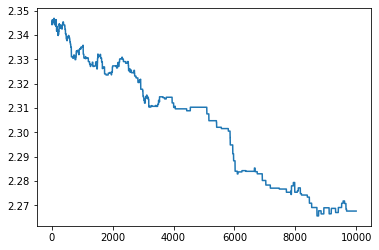

In [102]:
plt.plot(science_energy)
plt.show() 
plt.plot(science_prop)
plt.show() 
plt.plot(science_sep)
plt.show() 

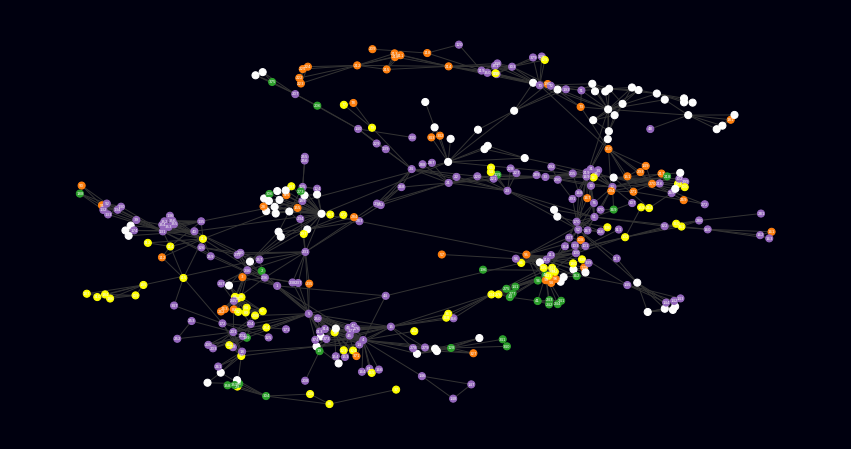

In [73]:
node_color2 = color_by_state(GG_science[-1], colors)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,8))

nx.draw(GG_science[-1], pos_science, node_color=node_color2, with_labels=True, **options4b)
ax.set_facecolor('#00000F'); ax.axis('off')
fig.set_facecolor('#00000F')

## Estableciendo el criterio de "separabilidad" $D_{ij}$

Considerando dos posibles estados tenemos:

$$D_{i,j}= |C_i|\cdot |C_j|,\qquad 0\leq D_{i,j}\leq \frac{N^2}{4}$$ 

Y la generalización para $n$ estados distintos es la siguiente

$$D_{n}=\prod_{i=1}^{n}|C_i|,\qquad 0\leq D_n\leq \left(\frac{N}{n}\right)^n$$ 

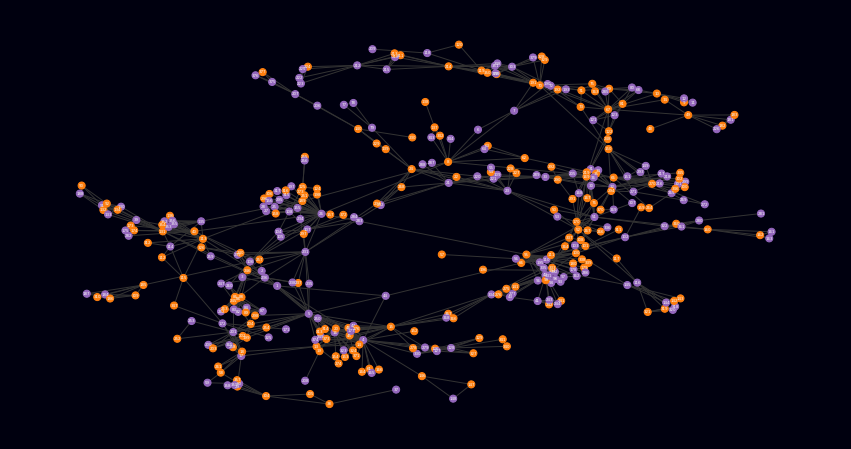

In [74]:
flips = 2
ratios = [1/2, 1/2]
p_ratios = [1/2, 1/2]

G_science2, state_list = initialize(G_science, ratios)
node_color = color_by_state(G_science2, colors)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,8))
nx.draw(G_science2, pos_science, node_color=node_color, with_labels=True, **options4b)
ax.set_facecolor('#00000F'); ax.axis('off')
fig.set_facecolor('#00000F')

GG_science2 = evolve_graph(G_science2, 0.05, 20000, p_ratios = p_ratios, state_list=state_list, flips=flips)

In [75]:
science_energy2 = evol_energy(GG_science2)
science_prop2 = evol_proportions(GG_science2, state_list)

In [76]:
science_sep2 = evol_separability(science_prop2)

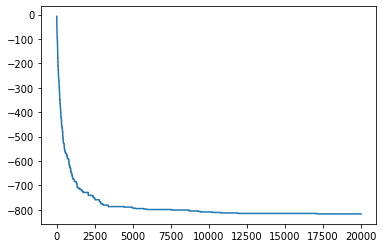

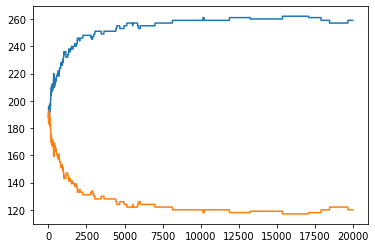

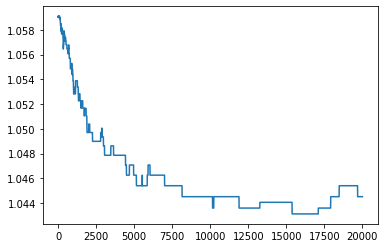

In [77]:
plt.plot(science_energy2)
plt.show() 
plt.plot(science_prop2)
plt.show() 
plt.plot(science_sep2)
plt.show() 

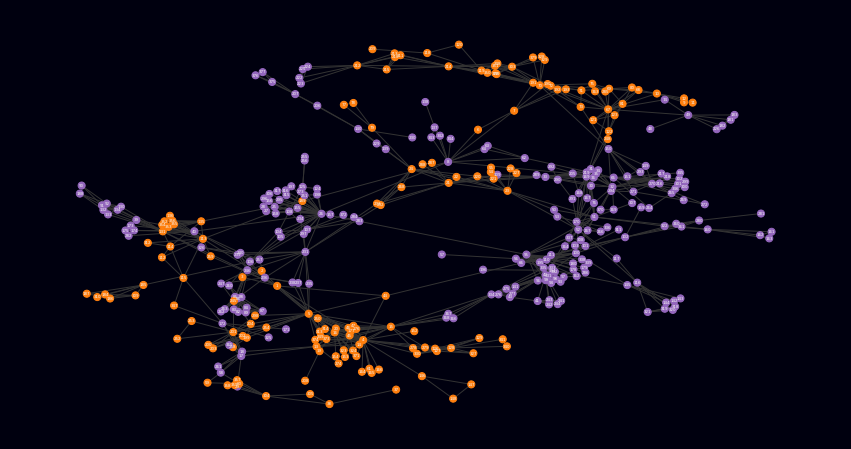

In [30]:
node_color2 = color_by_state(GG_science[-1], colors)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,8))

nx.draw(GG_science[-1], pos_science, node_color=node_color2, with_labels=True, **options4b)
ax.set_facecolor('#00000F'); ax.axis('off')
fig.set_facecolor('#00000F')